In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

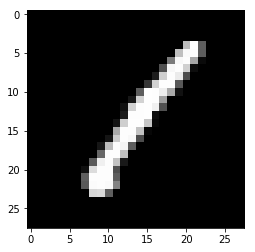

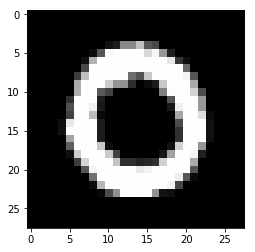

In [4]:
#加载数据
data = pd.read_csv('train.csv')
x = data.loc[:,data.columns != 'label'].values.astype(np.float32)
y = data['label'].values
x = x / 255.0
data = tf.data.Dataset.from_tensor_slices((x,y))
data_loader = data.repeat().shuffle(5000).batch(128).prefetch(1)
#熟悉数据
for i in range(2):    
    plt.imshow(np.reshape(x[i],[28,28]),cmap="gray")
    plt.show()

In [9]:
#构造模型

class network(tf.keras.Model):
    def __init__(self):
        super(network, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=5,activation=tf.nn.relu)
        self.maxpool1 =tf.keras.layers.MaxPool2D(2,strides=2)

        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,activation=tf.nn.relu)
        self.maxpool2 = tf.keras.layers.MaxPool2D(2,strides=2)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1024)
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.out = tf.keras.layers.Dense(10)

    def call(self,x,is_training=False):
        x = tf.reshape(x,[-1,28,28,1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x
conv = network()

In [ ]:
#训练
def cross_entropy_loss(x,y):   #定义损失函数
    y = tf.cast(y,tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=x)
    return tf.reduce_mean(loss)

def accuracy(y_pred,y_true):    #计算模型精度
    correct_pred = tf.equal(tf.argmax(y_pred,1),tf.cast(y_true,tf.int64))
    return tf.reduce_mean(tf.cast(correct_pred,tf.float32))

optimizer = tf.optimizers.SGD(0.01)

def run_optimizer(x,y):    #训练
    with tf.GradientTape() as g:
        pred = conv(x,is_training=True)
        loss = cross_entropy_loss(pred,y)
    training_variable = conv.trainable_variables
    gradient = g.gradient(loss,training_variable)
    optimizer.apply_gradients(zip(gradient,training_variable))

for i,(x_batch,y_batch) in enumerate(data_loader.take(1000),1):    #训练
    run_optimizer(x_batch,y_batch)
    if i%50==0:
        pred = conv(x_batch)
        acc = accuracy(pred,y_batch)
        print("%f"%(acc))

In [ ]:
#训练完成后保存模型参数，避免下次以下时还要训练
conv.save_weights('mannul_checkpoint')

In [ ]:
#加载模型，这里可以将训练的代码注释掉了
conv.load_weights('mannul_checkpoint')

In [ ]:
#定义绘图函数
Drawing = False  # 是否开始画图
Start = (-1, -1)

def mouse_event(event, x, y, flags, param):
    global start, Drawing
    # 左键按下：开始画图
    if event == cv2.EVENT_LBUTTONDOWN:
        Drawing = True
        start = (x, y)
    # 鼠标移动，画图
    elif event == cv2.EVENT_MOUSEMOVE:
        if Drawing:
            cv2.circle(img, (x, y), 8, (random.randint(185,255)), -1)
    # 左键释放：结束画图
    elif event == cv2.EVENT_LBUTTONUP:
        Drawing = False

In [10]:
img = np.zeros((512, 512, 1), np.uint8)
cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_event)

while(True):
    temp = img.copy()      #将temp送入训练好的模型中
    a = temp[:400,:400]
    cv2.imshow('a',cv2.resize(a,(28,28)))
    temp = temp.astype(np.float32)
    temp = cv2.resize(temp[:400,:400],(28,28))
    temp = np.reshape(temp,[1,784])

    pred = conv(temp, is_training=False)
    b = np.argmax(pred.numpy())

    cv2.imshow('image', img)
    # 按下a撤销之前所画的图像，并打印预测值
    if cv2.waitKey(1) == ord('a'):
        img = np.zeros((512, 512, 1), np.uint8)

        cv2.putText(img, str("pred:"+str(b)), (40, 450), cv2.FONT_HERSHEY_COMPLEX, 2.0, (100, 200, 200), 2)
    elif cv2.waitKey(1) == 27:
        break

NameError: name 'mouse_event' is not defined